### 建模概览

* baseline：特征提取的模型，10%数据，通过functionAPI重新建模
* model1：特征提取，1%数据，数据增强处理。
* model2：特征提取，10%数据，数据增强处理。
* model3：模型微调，10%数据，数据增强处理。
* model4：模型微调，100%数据，数据增强处理。

模型微调：用自己的数据训练超过原本特征提取中仅仅训练的1-3层。

In [53]:
models = {
  "baseline":"特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模",
  "model1":"特征提取，1%数据，数据增强处理",
  "model2":"特征提取，10%数据，数据增强处理",
  "model3":"模型微调，10%数据，数据增强处理",
  "model4":"模型微调，100%数据，数据增强处理"
}
models

{'baseline': '特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模',
 'model1': '特征提取，1%数据，数据增强处理',
 'model2': '特征提取，10%数据，数据增强处理',
 'model3': '模型微调，10%数据，数据增强处理',
 'model4': '模型微调，100%数据，数据增强处理'}

In [2]:
import datetime
datetime.datetime.now()

import tensorflow as tf

In [3]:
# import helper functions
from helper_functions import walk_through_dir, plot_loss_curves, unzip_data, create_tensorboard_callback

In [4]:
# Get 10% of the data of the 10 classes
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and0 images in '10_food_classes_10_percent'.
There are 10 directories and0 images in '10_food_classes_10_percent/test'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and250 images in '10_food_classes_10_percent/test/fried_rice'

In [64]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

使用tf.keras.preprocessing.image_dataset_from_directory()而不是ImageDataGenerator是因为它可以创建一个tf.data.Dataset而不是一个生成器。主要的好处是tf.data.Dataset是一个更快的API相比较于ImageDataGeneratorAPI。

In [65]:
# create data input
IMAGE_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                             image_size=IMAGE_SIZE,
                                                                             label_mode="categorical",
                                                                             batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMAGE_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [66]:
train_data_10_percent  # here the None can be seen as a placeholder for the batch size

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [67]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# see an example of the batch data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.20000000e+01 1.20000000e+01 1.00000000e+01]
   [2.17142849e+01 1.17142859e+01 9.71428585e+00]
   [2.30612240e+01 1.18469391e+01 1.02755108e+01]
   ...
   [1.38775497e+02 6.77755051e+01 2.53469753e+01]
   [1.40163300e+02 6.91632919e+01 2.71632957e+01]
   [1.41800980e+02 6.98009720e+01 2.98009739e+01]]

  [[2.07602024e+01 1.07602043e+01 8.76020432e+00]
   [1.80714283e+01 8.07142830e+00 6.07142830e+00]
   [2.36428566e+01 1.24285717e+01 1.08571434e+01]
   ...
   [1.32443848e+02 6.14438553e+01 1.94438534e+01]
   [1.42010223e+02 7.10102158e+01 2.90102196e+01]
   [1.41454010e+02 7.04540100e+01 2.84540138e+01]]

  [[1.99234695e+01 1.01377554e+01 7.49489784e+00]
   [2.21428566e+01 1.19285717e+01 9.50000000e+00]
   [2.35510216e+01 1.14030609e+01 9.78571415e+00]
   ...
   [1.33214279e+02 6.02142868e+01 1.92142868e+01]
   [1.43198944e+02 7.01989517e+01 2.91989498e+01]
   [1.39295975e+02 6.62959671e+01 2.52959690e+01]]

  ...

  [[1.24296120e+02 7.43674393e+01 4.48672867e+01]
   [1

### model0: baseline, feature extraction, 10%, function api

In [16]:
# create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze the model so the pre-trained patterns remains
base_model.trainable = False

# create inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
# If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass input to the base model
x = base_model(inputs)
print(x.shape)

# average pool the output of the base_model layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(x.shape)

# create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs and outputs in one model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(len(test_data_10_percent) * 0.25),
                              callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model0")])

(None, 7, 7, 1280)
(None, 1280)
Saving TensorBoard log files to: model_logs/fine_tuning_model0/20240112-092328
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8886 - accuracy: 0.4293 - val_loss: 1.3355 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.1545 - accuracy: 0.7320 - val_loss: 0.9364 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.8470 - accuracy: 0.8133 - val_loss: 0.7638 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.6882 - accuracy: 0.8480 - val_loss: 0.6518 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.5995 - accuracy: 0.8760 - val_loss: 0.5897 - val_accuracy: 0.8487


In [20]:
# check layers in base_model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [21]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [22]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

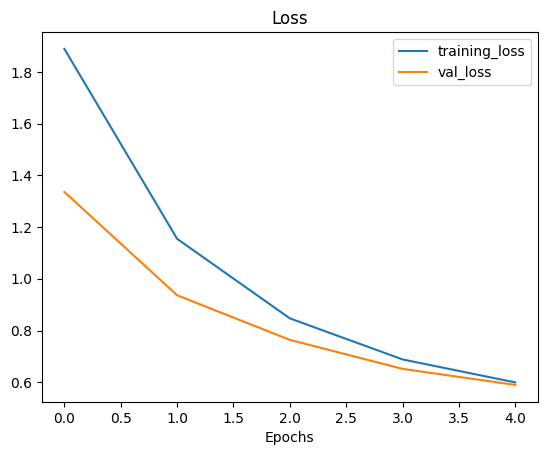

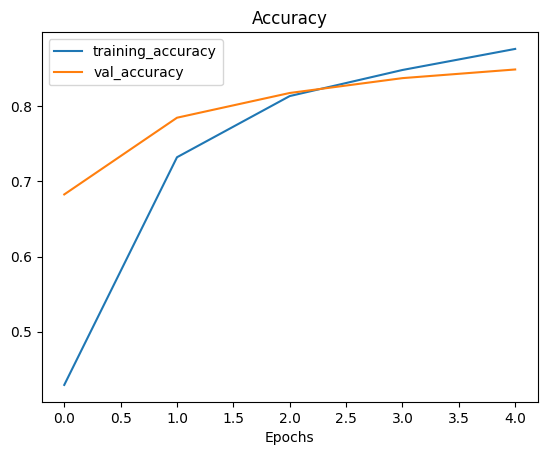

In [23]:
plot_loss_curves(history_model_0)

### 玩一玩2D池化层特征向量抽取过程

In [27]:
# define input shape
input_shape = (1, 4, 4, 3)

# set random seed
tf.random.set_seed(42)

# build random tensor with the defined shape
input_tensor = tf.random.normal(input_shape)
# input_tensor

# pass the tensor through the gloab max pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

# compare the shape before and after pass the tensor
print(input_tensor.shape)
print(global_average_pooled_tensor.shape)

(1, 4, 4, 3)
(1, 3)


In [29]:
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [28]:
# tf.reduce_mean works as the same
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

### model1:feature extraction, 1%, data augmentation

In [32]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-01-12 09:57:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:400a:80c::201b, 2404:6800:400a:804::201b, 2404:6800:400a:805::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:400a:80c::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  6.76MB/s    in 18s     

2024-01-12 09:58:15 (7.19 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [40]:
# !brew install wget

In [33]:
unzip_data("10_food_classes_1_percent.zip")

In [34]:
# create train and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [36]:
# walk through train dir
walk_through_dir(train_dir_1_percent)

There are 10 directories and0 images in '10_food_classes_1_percent/train/'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and7 images in '10_food_classes_1_percent/train/fried_rice'.


In [37]:
# create data input
IMAGE_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMAGE_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### 数据增强
和之前的通过ImageDataGenerator的数据预处理不同，现在数据增强也可以作为一个层直接放进模型中。这样做的好处是，第一可以用GPU进行训练，第二因为不会影响原本的图片，所以原本的图片可以导出来重新利用。

可以将数据增强层通过keras的Sequential方法添加进FunctionAPI的层中。这样当别人想用我们的模型的时候，就可以使用和我们一样的数据增强层。

In [38]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

In [39]:
data_augmentation

(-0.5, 599.5, 487.5, -0.5)

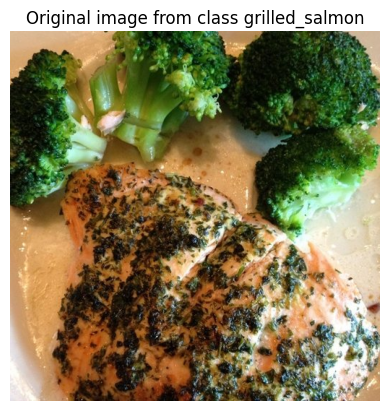

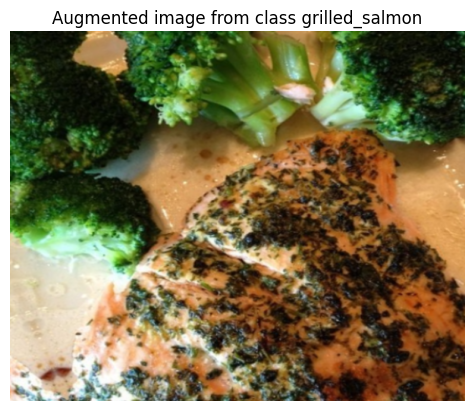

In [44]:
# visulize image before and after data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original image from class {target_class}")
plt.axis(False)

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.)) # requires normalization after augmentation
plt.title(f"Augmented image from class {target_class}")
plt.axis(False)

In [54]:
models

{'baseline': '特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模',
 'model1': '特征提取，1%数据，数据增强处理',
 'model2': '特征提取，10%数据，数据增强处理',
 'model3': '模型微调，10%数据，数据增强处理',
 'model4': '模型微调，100%数据，数据增强处理'}

In [55]:
# build model 1 with the data augmentation layer
# create base model with tf.keras.applications ! this is a model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze the model so the pre-trained patterns remains
base_model.trainable = False

# create inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# add data augmentation layer to the input
x = data_augmentation(inputs)

# pass x to the base model
x = base_model(x, training=False)
print(x.shape)

# average pool the output of the base_model layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(x.shape)

# create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs and outputs in one model
model_1 = tf.keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(len(test_data) * 0.25),
                              callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model1")])

(None, None, None, 1280)
(None, 1280)
Saving TensorBoard log files to: model_logs/fine_tuning_model1/20240113-123552
Epoch 1/5
3/3 [==============================] - 17s 6s/step - loss: 2.3401 - accuracy: 0.1143 - val_loss: 2.2385 - val_accuracy: 0.1530
Epoch 2/5
3/3 [==============================] - 13s 6s/step - loss: 2.1460 - accuracy: 0.1286 - val_loss: 2.1274 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 13s 6s/step - loss: 1.9981 - accuracy: 0.4286 - val_loss: 2.0190 - val_accuracy: 0.3207
Epoch 4/5
3/3 [==============================] - 13s 6s/step - loss: 1.8470 - accuracy: 0.4857 - val_loss: 1.9468 - val_accuracy: 0.3717
Epoch 5/5
3/3 [==============================] - 13s 6s/step - loss: 1.7108 - accuracy: 0.6000 - val_loss: 1.8663 - val_accuracy: 0.4194


In [56]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [57]:
model_1.evaluate(test_data)

79/79 [==============================] - 47s 596ms/step - loss: 1.8489 - accuracy: 0.4400


[1.8489106893539429, 0.4399999976158142]

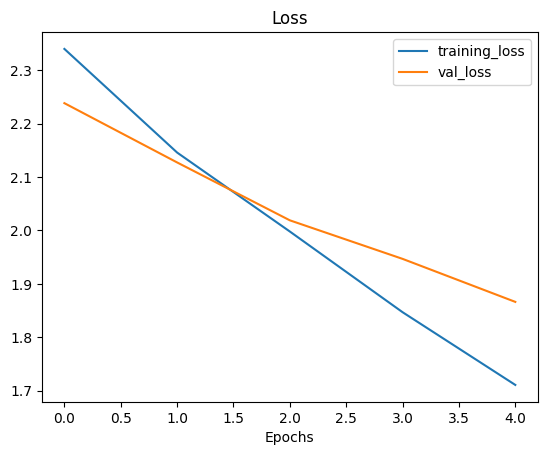

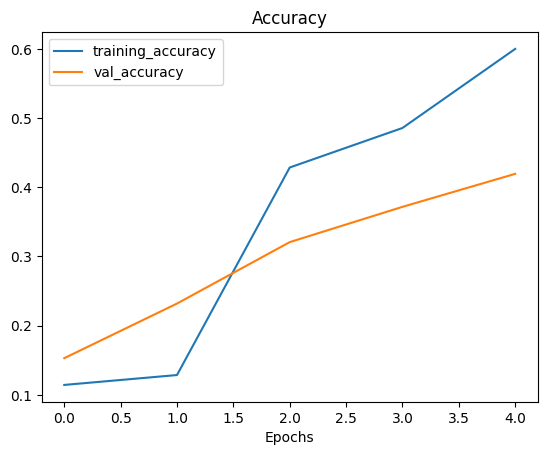

In [58]:
plot_loss_curves(history_model_1)

### model2:Feature Extraction,10%data, data augmentation

In [59]:
models

{'baseline': '特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模',
 'model1': '特征提取，1%数据，数据增强处理',
 'model2': '特征提取，10%数据，数据增强处理',
 'model3': '模型微调，10%数据，数据增强处理',
 'model4': '模型微调，100%数据，数据增强处理'}

In [70]:
data_augmentation

In [71]:
# build model 2 with the data augmentation layer
# create base model with tf.keras.applications ! this is a model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze the model so the pre-trained patterns remains
base_model.trainable = False

# create inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# add data augmentation layer to the input
x = data_augmentation(inputs)

# pass x to the base model
x = base_model(x, training=False)
print(x.shape)

# average pool the output of the base_model layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(x.shape)

# create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs and outputs in one model
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_2 = model_1.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(len(test_data) * 0.25),
                              callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model2")])

(None, None, None, 1280)
(None, 1280)
Saving TensorBoard log files to: model_logs/fine_tuning_model2/20240113-124729
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 1.7016 - accuracy: 0.5067 - val_loss: 1.3248 - val_accuracy: 0.6711
Epoch 2/5
24/24 [==============================] - 28s 1s/step - loss: 1.2749 - accuracy: 0.6627 - val_loss: 1.0052 - val_accuracy: 0.7582
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 1.0684 - accuracy: 0.7173 - val_loss: 0.8222 - val_accuracy: 0.7862
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.9290 - accuracy: 0.7560 - val_loss: 0.7412 - val_accuracy: 0.8043
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.8327 - accuracy: 0.7960 - val_loss: 0.6783 - val_accuracy: 0.8141


In [124]:
# create a function for model creation
def create_base_model(input_shape=(224, 224, 3),
                      training=False,
                      learning_rate=0.001,
                      output_shape=10):
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = False
    # create inputs
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
    # add data augmentation layer to the input
    x = data_augmentation(inputs)
    # pass x to the base model
    x = base_model(x, training=training)
    # average pool the output of the base_model layer
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    # create the output activation layer
    outputs = tf.keras.layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    # combine the inputs and outputs in one model
    model = tf.keras.Model(inputs, outputs)
    # compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

In [75]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

### 回调函数modelcheckpoint
`ModelCheckpoint` 是一个回调函数（Callback）类，用于在训练期间保存模型的权重。它属于 Keras 框架的一部分，用于保存训练过程中性能最好的模型权重，通常是基于验证集上的表现。这对于避免过拟合以及在训练中选择模型的最佳版本非常有用。

下面是一个简单的示例，演示如何使用 `ModelCheckpoint`：

```python
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 创建一个简单的模型
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dense(1, activation='sigmoid'))

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 创建 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('best_model.h5',  # 保存模型权重的文件名
                             monitor='val_accuracy',  # 监控的指标，例如验证集上的准确度
                             save_best_only=True,  # 只保存性能最好的模型
                             mode='max',  # 对于监控指标，'max' 表示最大化，'min' 表示最小化
                             verbose=1)  # 显示保存信息

# 模型训练，将 ModelCheckpoint 回调添加到 callbacks 列表中
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[checkpoint])
```

在上述代码中，`ModelCheckpoint` 配置为在每个 epoch 结束时检查验证集上的准确度，如果当前模型的准确度优于之前保存的最佳模型，则保存当前模型的权重到名为 `'best_model.h5'` 的文件中。

这样，即使在训练过程中发生过拟合，你仍然可以获得在验证集上性能最好的模型。

而且有时候没有时间一直等模型结束，通过回调函数，可以下次继续训练。

In [76]:
# setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a modelcheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [78]:
# fit the model saving checkpoints every epoch
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model2"),
                                         checkpoint_callback])

Saving TensorBoard log files to: model_logs/fine_tuning_model2/20240113-143435
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0802 - accuracy: 0.3040
Epoch 1: val_loss improved from inf to 1.53657, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 1s/step - loss: 2.0802 - accuracy: 0.3040 - val_loss: 1.5366 - val_accuracy: 0.6464
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.6547
Epoch 2: val_loss improved from 1.53657 to 1.10269, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 1.4182 - accuracy: 0.6547 - val_loss: 1.1027 - val_accuracy: 0.7303
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.7493
Epoch 3: val_loss improved from 1.10269 to 0.87508, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [===============

In [79]:
# evaluate the test data
results_model_2 = model_2.evaluate(test_data)
results_model_2

79/79 [==============================] - 47s 593ms/step - loss: 0.6679 - accuracy: 0.8244


[0.667860746383667, 0.824400007724762]

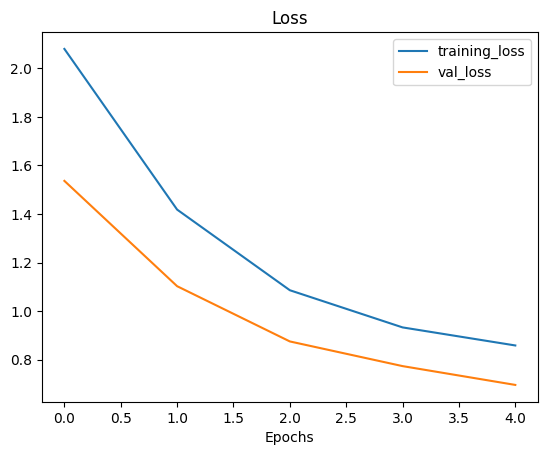

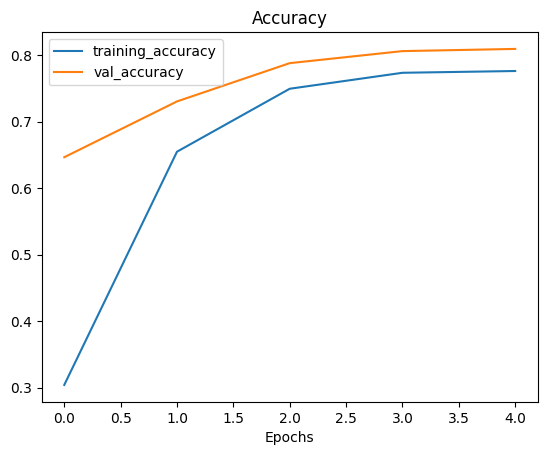

In [80]:
# plot the loss curves
plot_loss_curves(history_model_2)

In [81]:
# load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 48s 601ms/step - loss: 0.6679 - accuracy: 0.8244


In [82]:
results_model_2 == loaded_weights_model_results

True

In [83]:
models

{'baseline': '特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模',
 'model1': '特征提取，1%数据，数据增强处理',
 'model2': '特征提取，10%数据，数据增强处理',
 'model3': '模型微调，10%数据，数据增强处理',
 'model4': '模型微调，100%数据，数据增强处理'}

### model3:Fine-tuning,10%data,data_augmentation

微调的意义在于，让模型更接近我们的问题。

微调经常**跟在几次特征抽取之后**比较好。并且特征抽取需要用稍微多点的数据。

In [86]:
model_2.summary()
model_2.name

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

'model_3'

In [85]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable {layer.trainable}.")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x145d03a10> | Trainable True.
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x29954d490> | Trainable True.
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x145f69990> | Trainable False.
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x14617d7d0> | Trainable True.
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x146116950> | Trainable True.


In [87]:
# access the base layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [88]:
# how many layers are trainable in our model_2_base_model
len(model_2_base_model.trainable_variables)

0

In [89]:
# check which layers are tuneable
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

为了微调最后的10层，首先需要解冻所有的层，然后再将除了最后十层的层再次冻结。
学会控制层。

In [91]:
# make all the layer in model_2_base_model trainable
model_2_base_model.trainable = True

# freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

# recompile the whole model(always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                metrics=["accuracy"]) # ir is 10x lower than before for fine tuning    

**使用更低的学习率**可以让微调更慢一些，更渐进一些，而不是太快的重写权重。

In [92]:
# check which layers are tuneable(trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [93]:
# in the model_2 how many trainable variables do we have now
len(model_2.trainable_variables)

12

In [99]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


在原先训练的5epochs基础上继续进行微调训练。

In [102]:
# fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model (same as model 2 except with more trainable layers)
history_model_3 = model_2.fit(train_data_10_percent,
                            epochs=fine_tune_epochs,
                            validation_data=test_data,
                            initial_epoch=history_model_2.epoch[-1], # start from last model history
                            validation_steps=int(0.25 * len(test_data)),
                            callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model3")])

Saving TensorBoard log files to: model_logs/fine_tuning_model3/20240113-161147
Epoch 5/10
24/24 [==============================] - 35s 1s/step - loss: 0.8106 - accuracy: 0.7200 - val_loss: 0.5533 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 31s 1s/step - loss: 0.4847 - accuracy: 0.8613 - val_loss: 0.5512 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 30s 1s/step - loss: 0.3624 - accuracy: 0.8907 - val_loss: 0.5084 - val_accuracy: 0.8388
Epoch 8/10
24/24 [==============================] - 30s 1s/step - loss: 0.2936 - accuracy: 0.9040 - val_loss: 0.5515 - val_accuracy: 0.8289
Epoch 9/10
24/24 [==============================] - 31s 1s/step - loss: 0.2408 - accuracy: 0.9200 - val_loss: 0.4831 - val_accuracy: 0.8487
Epoch 10/10
24/24 [==============================] - 31s 1s/step - loss: 0.1862 - accuracy: 0.9453 - val_loss: 0.4561 - val_accuracy: 0.8602


In [103]:
results_model_3 = model_2.evaluate(test_data)

79/79 [==============================] - 48s 610ms/step - loss: 0.4254 - accuracy: 0.8664


In [105]:
# history compare  function
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compare two model history objects.
    """
    # get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    print(len(acc))
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # get new history measurements
    new_acc = new_history.history["accuracy"]
    new_loss = new_history.history["loss"]
    print(len(new_acc))
    new_val_acc = new_history.history["val_accuracy"]
    new_val_loss = new_history.history["val_loss"]
    
    # combine original with new history
    total_acc = acc + new_acc
    total_loss = loss + new_loss
    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss
    print(len(total_acc))
    
    # make plots
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

5
6
11


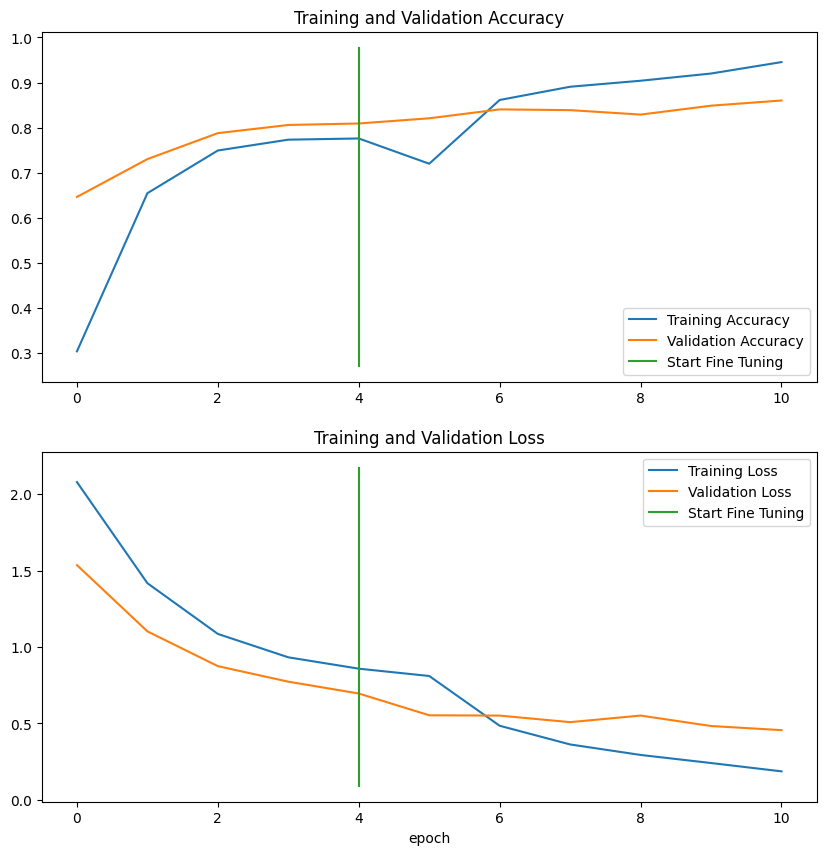

In [107]:
compare_historys(original_history=history_model_2,
                 new_history=history_model_3,
                 initial_epochs=5)

### model4:Fine tuning, 100%data, data augmentation

In [109]:
models

{'baseline': '特征提取的模型，10%数据，不处理数据，通过functionAPI重新建模',
 'model1': '特征提取，1%数据，数据增强处理',
 'model2': '特征提取，10%数据，数据增强处理',
 'model3': '模型微调，10%数据，数据增强处理',
 'model4': '模型微调，100%数据，数据增强处理'}

In [110]:
# set up data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [113]:
walk_through_dir(train_dir)

There are 10 directories and0 images in '10_food_classes_all_data/train/'.
There are 0 directories and750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and750 images in '10_food_classes_all_data/train/fried_rice'.


In [115]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
# Note: this is the same test dataset we've beening using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### 实验说明🧪：
为了和model2进行比较，我们要用checkpoint重新载入5个epoch之前的权重，然后在all数据集上进行训练，以和model3进行比较

model3和model4都是在model2的基础上进行的，使用同样的评价数据test data

起点都必须是checkpoint的权重

In [117]:
# evaluate model 3 (model_2 train on 10% data by fine tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 47s 599ms/step - loss: 0.4254 - accuracy: 0.8664


[0.4254063069820404, 0.8664000034332275]

In [118]:
results_model_3

[0.42540639638900757, 0.8664000034332275]

In [125]:
# to keep clean ,create new instance of model 4
model_4 = create_base_model(learning_rate=0.0001) # 10x lower for fine tuning

In [126]:
model_4.load_weights(checkpoint_path)

In [127]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [128]:
print(len(model_4.trainable_variables))

2


In [129]:
# check if the result is same as original model 2
model_4.evaluate(test_data)

79/79 [==============================] - 48s 588ms/step - loss: 0.6679 - accuracy: 0.8244


[0.6678605675697327, 0.824400007724762]

In [131]:
results_model_2 # check they are the same

[0.667860746383667, 0.824400007724762]

In [135]:
results_model_3 # this is the fine tuning 10% data result

[0.42540639638900757, 0.8664000034332275]

In [133]:
# check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_4.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [137]:
# unfreeze the top 10 layers in model_4 base model
model_4_base_model = model_4.layers[2]
model_4_base_model.trainable = True

# freeze all layers except for the last 10
for layer in model_4_base_model.layers[:-10]:
    layer.trainable = False

In [138]:
# check, always check
for layer_number, layer in enumerate(model_4_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [139]:
# recompile 
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [145]:
# let's fine tuning
fine_tune_epochs = initial_epochs + 5

history_model_4 = model_4.fit(train_data_10_classes_full,
                              epochs=fine_tune_epochs,
                              initial_epoch=history_model_2.epoch[-1],
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tuning_model4")])

Saving TensorBoard log files to: model_logs/fine_tuning_model4/20240113-184352
Epoch 5/10
235/235 [==============================] - 200s 849ms/step - loss: 0.4380 - accuracy: 0.8565 - val_loss: 0.2572 - val_accuracy: 0.9293
Epoch 6/10
235/235 [==============================] - 193s 821ms/step - loss: 0.4154 - accuracy: 0.8651 - val_loss: 0.2687 - val_accuracy: 0.9145
Epoch 7/10
235/235 [==============================] - 200s 850ms/step - loss: 0.4016 - accuracy: 0.8669 - val_loss: 0.2447 - val_accuracy: 0.9243
Epoch 8/10
235/235 [==============================] - 199s 847ms/step - loss: 0.3874 - accuracy: 0.8708 - val_loss: 0.2464 - val_accuracy: 0.9293
Epoch 9/10
235/235 [==============================] - 197s 835ms/step - loss: 0.3675 - accuracy: 0.8792 - val_loss: 0.2742 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 194s 824ms/step - loss: 0.3590 - accuracy: 0.8815 - val_loss: 0.2081 - val_accuracy: 0.9260


In [146]:
results_model_4 = model_4.evaluate(test_data)
results_model_4

79/79 [==============================] - 62s 784ms/step - loss: 0.2412 - accuracy: 0.9196


[0.24118195474147797, 0.9196000099182129]

In [147]:
results_model_3

[0.42540639638900757, 0.8664000034332275]

6
6
12


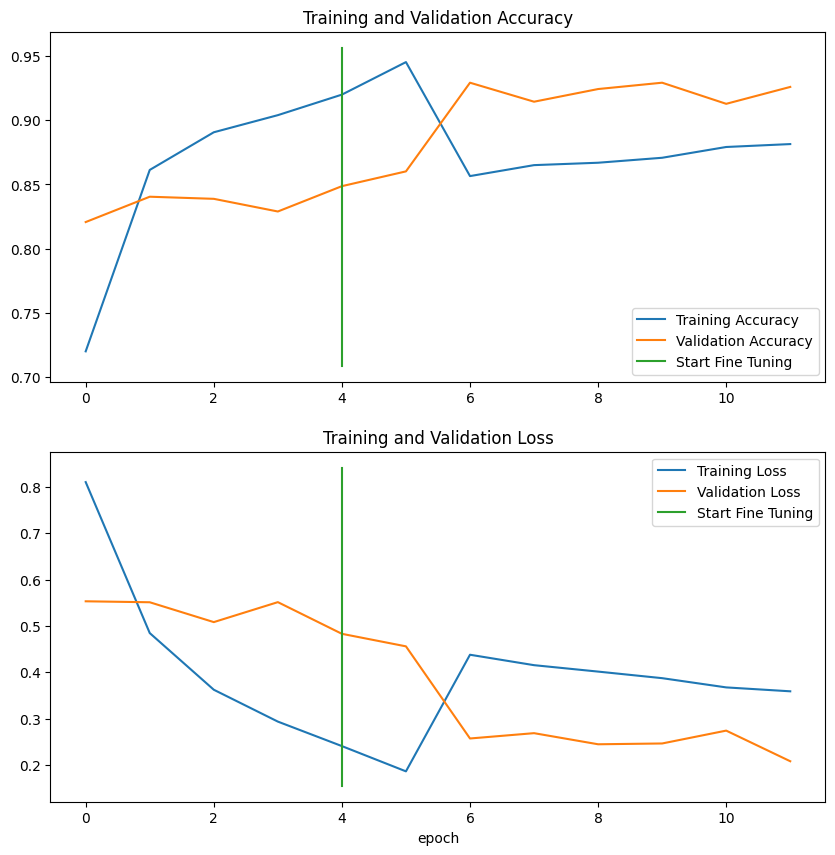

In [148]:
compare_historys(original_history=history_model_3,
                 new_history=history_model_4,
                 initial_epochs=5)